In [17]:
import pandas as pd
import numpy as np
from sklearn import tree

# Задача 1
Проведите анализ данных экспресии генов (https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE26728) :

* 1 Информация о каком количестве генов есть в исследовании? Есть ли в данных дубликаты по генам? Что еще вы можете сказать о данных?
* 2 Посчитайте средние значения экспресии каждого из генов в контроле, low_dose и high_dose. Если обнаружите дубликаты, усредните и их.
* 3 Воспользуйтесь деревом решений высотой 2 и постройте классификаторы control vs low_dose, control vs high_dose. Какие гены оказались лучшими признаками для разделения? Совпали ли признаки в деревьях?

## 1. 

Информация о каком количестве генов есть в исследовании? Есть ли в данных дубликаты по генам? Что еще вы можете сказать о данных?

Скачаем общую таблицу экспрессии с помощью phantasus. Файл data.gct

ID генов для конкретной платформы из эксперимента взяты с https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GPL7042 . Файл GPL7042-9573.txt GitHub не позволяет добавить его в репозиторий, поэтому прикладываю в README ссылку на гуглодрайв с файлом.

In [2]:
id_table = pd.read_table("GPL7042-9573.txt")
id_df = id_table[['ID', 'GENE']]
print(id_df.shape)
print(id_df['ID'].isna().any())
print(id_df['ID'].duplicated().any())

(41247, 2)
True
False


/home/karl-crl/.apps/anaconda3/envs/working_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df = pd.read_table("data.gct")
print(df.shape)
print(df['id/title'].isna().any())
print(df['id/title'].duplicated().any())
genes = list(df['id/title'])

(22514, 21)
False
False


In [4]:
id_intersec = id_df[id_df['ID'].isin(genes)]

In [5]:
print(f'Всего "генов", т.е. id платформы в датасете: {df.shape[0]}')
print(f"Всего непустых генов, соответствующий id платформы: {np.sum(id_intersec['GENE'].count())}")
print(f"Всего уникальных генов из них: {id_intersec['GENE'].unique().shape[0]}")

Всего "генов", т.е. id платформы в датасете: 22514
Всего непустых генов, соответствующий id платформы: 20702
Всего уникальных генов из них: 13322


Есть ли пусте значения в колонках?

In [6]:
for col in df.columns:
    print(f"Column {col}: {df[col].isna().any()}")

Column id/title: False
Column GENE_SYMBOL: True
Column ID: True
Column liver_control_rep1: False
Column liver_control_rep2: False
Column liver_control_rep3: False
Column liver_control_rep4: False
Column liver_control_rep5: False
Column liver_control_rep6: False
Column liver_BPALowDose_rep1: False
Column liver_BPALowDose_rep2: False
Column liver_BPALowDose_rep3: False
Column liver_BPALowDose_rep4: False
Column liver_BPALowDose_rep5: False
Column liver_BPALowDose_rep6: False
Column liver_BPAHighDose_rep1: False
Column liver_BPAHighDose_rep2: False
Column liver_BPAHighDose_rep3: False
Column liver_BPAHighDose_rep4: False
Column liver_BPAHighDose_rep5: False
Column liver_BPAHighDose_rep6: False


Только в GENE_SYMBOL и ID

## 2

Посчитайте средние значения экспресии каждого из генов в контроле, low_dose и high_dose. Если обнаружите дубликаты, усредните и их.

In [7]:
id_intersec.columns = ['id/title', 'GENE']

In [8]:
df = df.merge(id_intersec, on = 'id/title')

In [9]:
df = df.dropna(subset=['GENE'])

In [10]:
df = df.drop(columns=['id/title', 'GENE_SYMBOL', 'ID'])

In [11]:
df = df.groupby(['GENE']).mean()

In [12]:
df_control = df[df.columns[0:6]]
df_low = df[df.columns[6:12]]
df_high = df[df.columns[12:18]]

Среднее для контроля

In [13]:
mean_control = df_control.mean(axis=1)
mean_control.index = df.index
mean_control

GENE
11287.0        15.355667
11298.0         6.124500
11302.0         7.779000
11303.0        11.235167
11305.0         8.555083
                 ...    
100505263.0     9.226667
100505358.0     6.007833
100526796.0     6.003500
100529082.0    14.529500
100616095.0     7.918500
Length: 13321, dtype: float64

Среднее для низкой дозы

In [14]:
mean_low = df_low.mean(axis=1)
mean_low.index = df.index
mean_low

GENE
11287.0        15.364167
11298.0         5.995500
11302.0         7.540667
11303.0        11.586667
11305.0         8.476667
                 ...    
100505263.0     7.808333
100505358.0     6.289167
100526796.0     5.846833
100529082.0    14.468333
100616095.0     8.021667
Length: 13321, dtype: float64

In [15]:
mean_high = df_high.mean(axis=1)
mean_high.index = df.index
mean_high

GENE
11287.0        15.365167
11298.0         6.137000
11302.0         7.862000
11303.0        11.548167
11305.0         8.689417
                 ...    
100505263.0     7.832833
100505358.0     6.286667
100526796.0     5.954667
100529082.0    14.748500
100616095.0     7.944167
Length: 13321, dtype: float64

## 3
Воспользуйтесь деревом решений высотой 2 и постройте классификаторы control vs low_dose, control vs high_dose. Какие гены оказались лучшими признаками для разделения? Совпали ли признаки в деревьях?

[Text(167.4, 163.07999999999998, 'X[6131] <= 9.459\ngini = 0.5\nsamples = 12\nvalue = [6, 6]'),
 Text(83.7, 54.360000000000014, 'gini = 0.0\nsamples = 6\nvalue = [6, 0]'),
 Text(251.10000000000002, 54.360000000000014, 'gini = 0.0\nsamples = 6\nvalue = [0, 6]')]

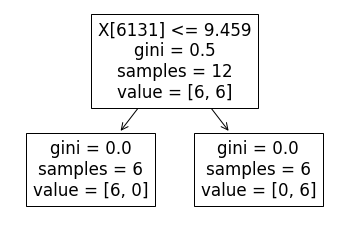

In [21]:
df_control_vs_low = df[df.columns[0:12]]
df_control_vs_low = df_control_vs_low.transpose()
tre = tree.DecisionTreeClassifier(max_depth = 2, random_state = 0, min_impurity_decrease = 0)
tre.fit(df_control_vs_low.to_numpy(), [0]*6 + [1]*6)
tree.plot_tree(tre)

[Text(167.4, 163.07999999999998, 'X[7146] <= 7.172\ngini = 0.5\nsamples = 12\nvalue = [6, 6]'),
 Text(83.7, 54.360000000000014, 'gini = 0.0\nsamples = 6\nvalue = [0, 6]'),
 Text(251.10000000000002, 54.360000000000014, 'gini = 0.0\nsamples = 6\nvalue = [6, 0]')]

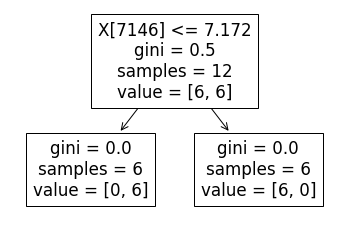

In [22]:
df_control_vs_high = df[df.columns[0:6].append(df.columns[12:])]
df_control_vs_high = df_control_vs_high.transpose()
tre = tree.DecisionTreeClassifier(max_depth = 2, random_state = 0, min_impurity_decrease = 0)
tre.fit(df_control_vs_high.to_numpy(), [0]*6 + [1]*6)
tree.plot_tree(tre)

Оба классификатора смогли построить только деревья размера 1. Дальнейшее деление не приводит к уменьшению impurity. 

Признаки в деревьях не совпали.

С этим может справится random forest на пеньках, но это просто к тому, что можно было бы сделать.

# Задача 2

Ознакомьтесь с данными экспрессии генов: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE26728

Ответьте на следующие вопросы:

* Что исследовалось?

Влияние низких и высоких доз BPA на транскриптом печени мыши. Основная цель --- выявить какое-либо влияние низких доз BPA, чтобы понять, могут ли утечки малых доз BPA в промышленности влиять на здоровье людей.

* Какие дозы BPA использовались?

Контроль --- отсутствие BPA, low_dose --- 50 µg/kg/day, high_dose --- 5000 µg/kg/day.

* Сколько особей использовалось?

18 мужских особей.